<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".


Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.


В обучающей выборке *train_sessions.csv*:

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем *site_dic.pkl*)
Признаки time_j – время посещения сайтов site_j
Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)
Задача – сделать прогнозы для сессий в тестовой выборке (*test_sessions.csv*), определить, принадлежат ли они Элис. Не обязательно ограничиваться только предложенной выборкой *train_sessions.csv* – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

In [1]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
import pickle
from collections import Counter
import math
import operator
from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from scipy.sparse import hstack


Reading original data

In [2]:
# Read the training and test data sets
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
times = ['time%s' % i for i in range(1, 11)]

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
16532,t3.ssl.ak.dynamic.tiles.virtualearth.net
37060,www.ojocientifico.com
19840,i1-js-14-3-01-12160-111393771-i.init.cedexis-r...
25009,www.logo00.com
30896,atrecherche.blogspot.fr


In [4]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

Separate target feature 

In [5]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [6]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [8]:
# new_features = ['start_session_hour', 'start_session_day_night', 'start_session_morning', 
#                 'start_session_day_of_the_week',  
#                'start_session_15','start_session_16','start_session_18', 
#                 'start_session_year_14','start_session_year_13', 'is_weekend']

# new_features = ['start_session_hour',  
#                 'start_session_day_of_the_week', 
#                 'alice_top_words',
#                'session_time',
#                'year_month']

# OHE = ['start_session_hour',  
#                 'start_session_day_of_the_week', 
#                 'alice_top_words',
#       'year_month']


new_features = [ 
                'alice_top_words',
               'session_time',
               'year_month',
               '15_19']

OHE = [
                'alice_top_words',
      'year_month']


from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


times = ['time%s' % i for i in range(1, 11)]
train_df['session_time'] = (train_df[times].max(axis=1) - train_df['time1']).dt.seconds//60
test_df['session_time'] = (test_df[times].max(axis=1) - test_df['time1']).dt.seconds//60



alice_words = train_df[(train_df['target'] == 1)][sites]
alice_words['alice_text'] = alice_words[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)
alice_words_list = [word for word in alice_words['alice_text'].apply(lambda x: x.split(' '))]
alice_flatten = list(np.array(alice_words_list).flat)
alice_most_freq_sites = Counter(alice_flatten)#.most_common(100)

alice_time = train_df[(train_df['target'] == 1)]['session_time']

alice_time.describe()
print(alice_most_freq_sites.most_common(50))
alice_top_sites  = sorted(alice_most_freq_sites, key=alice_most_freq_sites.get, reverse=True)[:10]


#print(train_df[times].max(axis=1))
#train_df.head()
#alice_top_sites.remove('0')
#print(alice_top_sites)

print(train_df.columns)
print(test_df.columns)

vectorizer = TfidfVectorizer(ngram_range=(1,7), max_features=150000, max_df=0.5)
vectorizer.fit(site_dict.keys())

[('77', 1382), ('80', 1354), ('76', 1307), ('29', 897), ('21', 857), ('81', 609), ('879', 522), ('22', 522), ('75', 451), ('82', 447), ('23', 437), ('35', 381), ('881', 371), ('37', 293), ('33', 291), ('3000', 286), ('733', 274), ('30', 272), ('78', 236), ('941', 215), ('7832', 209), ('52', 206), ('704', 204), ('0', 201), ('2078', 188), ('617', 159), ('1057', 155), ('942', 153), ('270', 151), ('335', 150), ('12619', 150), ('855', 143), ('3', 129), ('1514', 126), ('3559', 125), ('3560', 124), ('265', 123), ('39', 121), ('2077', 121), ('1515', 110), ('32', 109), ('229', 106), ('14', 100), ('616', 98), ('38', 98), ('1307', 93), ('106', 82), ('99', 81), ('940', 81), ('8', 80)]
Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'target', 'session_time'],
      dtype='object')
Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=150000, min_df=1,
        ngram_range=(1, 7), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [10]:
def build_features(df):
    #df["start_session_year_13"] = (df['time1'].dt.year == 13).astype(int)
    #df["start_session_year_14"] = (df['time1'].dt.year == 14).astype(int)
    
    #df['session_ed'] = df[times].apply(lambda x: x !=None, axis=1)
    
    
    df["start_session_hour"] = df['time1'].dt.hour
    df["start_session_day_night"] = ((df['time1'].dt.hour > 20) | (df['time1'].dt.hour < 7)).astype(int)
    df["start_session_morning"] = ((df['time1'].dt.hour > 6) & (df['time1'].dt.hour < 11)).astype(int)
    
    df['start_session_month'] = df['time1'].dt.month
    df['start_session_day'] = df['time1'].dt.day
    #df['start_session_week'] = df['time1'].dt.week
    df['start_session_week'] = (df['time1'].dt.day) // 7
    df['year_month'] = df['time1'].dt.year.astype(str)+df['time1'].dt.month.astype(str)

    df['start_session_day_of_the_week'] = df['time1'].dt.dayofweek
    #df['start_session_15'] = (df['time1'].dt.hour == 15).astype(int) 
    #df['start_session_16'] = (df['time1'].dt.hour == 16).astype(int)
    #df['start_session_18'] = (df['time1'].dt.hour == 18).astype(int)
    df["is_weekend"] = df['time1'].dt.weekday.isin([5,6])*1 #индикатор выходных
    df["12_14_16_19"] = (((df['time1'].dt.hour >= 12) & (df['time1'].dt.hour <= 14)) | 
                        ((df['time1'].dt.hour >= 16) & (df['time1'].dt.hour <= 19))).astype(int)
   
    df["09_13"] = (df['time1'].dt.hour >= 9) & (df['time1'].dt.hour <= 13)
    df["13_14"] = (df['time1'].dt.hour > 13) & (df['time1'].dt.hour <= 14)
    df["14_18"] = (df['time1'].dt.hour > 14) & (df['time1'].dt.hour <= 18)
    
    df["15_19"] =  ((df['time1'].dt.hour >= 15) & (df['time1'].dt.hour <= 19)).astype(int)
   
    print(df['session_time'].unique())

    
    #---------------------------------------
    df['text'] = df[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)
    df['text'] = df['text'].apply(lambda x: x.replace('0', ''))
    #vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=100000)
    bag_of_words = (df['text'].apply(lambda x: x.strip().split(' ')).astype(str)).values
    tfidf_data = vectorizer.transform(df['text'].values)
    #pr
    
    #tfidf = TfidfTransformer()
    #tfidf_data = tfidf.fit_transform(csr_matrix((df['text'].apply(lambda x: x.strip().split(' ')).astype(str))))
    
    #---------------------------------------
    
    df['alice_top_words'] = (df[sites].astype(str).isin(alice_top_sites)==True).sum(axis=1)


    print(df['alice_top_words'].unique())

    
    train_data = pd.get_dummies(df[new_features], columns=OHE)
    
    
    
    #print(df.head())
    #print(df['start_session_week'].unique())
   
    #print(train_data.columns.tolist())
    #print(type(train_data)
    fig, ax = plt.subplots(figsize=(20,20)) 

    sns.heatmap(train_data.corr(), ax=ax);
    plt.show()
    
    #//todo change fir_transform for full list
    #------------------------------------------
    #scaler = StandardScaler()
    #train_data = scaler.fit_transform(df[new_features], y_train)
    #train_full = hstack((csr_matrix(train_data), tfidf_data), format='csr')
    #----------------------------------
    print(train_data.shape)
    scaler = StandardScaler(with_mean=False)
    train_full = hstack((csr_matrix(train_data), tfidf_data), format='csr')
    train_full = scaler.fit_transform(train_full)
    #-------------------------------------------------
    #scaler = StandardScaler()
    #train_data = scaler.fit_transform(train_data)
    #train_full = hstack((csr_matrix(train_data), tfidf_data), format='csr')
    #-------------------
    #scaler = StandardScaler()
    #train_full = scaler.fit_transform(train_data) 0.74
    
    
    
    print(train_full.shape)
    
    return train_full

In [11]:
# from functools import reduce
# import numpy as np

# # texts = [['i', 'have', 'a', 'cat'],
# #          ['he', 'have', 'a', 'dog'],
# #          ['he', 'and', 'i', 'have', 'a', 'cat', 'and', 'a', 'dog']]



# dictionary = list(enumerate(set(reduce(lambda x, y: x + y, texts))))

# def vectorize(text):
#     vector = np.zeros(len(dictionary))
#     for i, word in dictionary:
#         num = 0
#         for w in text:
#             if w == word:
#                 num += 1
#         if num:
#             vector[i] = num
#     return vector

# for t in texts:
#     print(vectorize(t))

[ 0 29  1 19  8 21  4  3 22  6  2 15  5 16  9 11  7 24 13 23 25 12 10 28
 27 26 14 20 18 17 30]
[ 0  2  1  3  5  9  4  6  7  8 10]


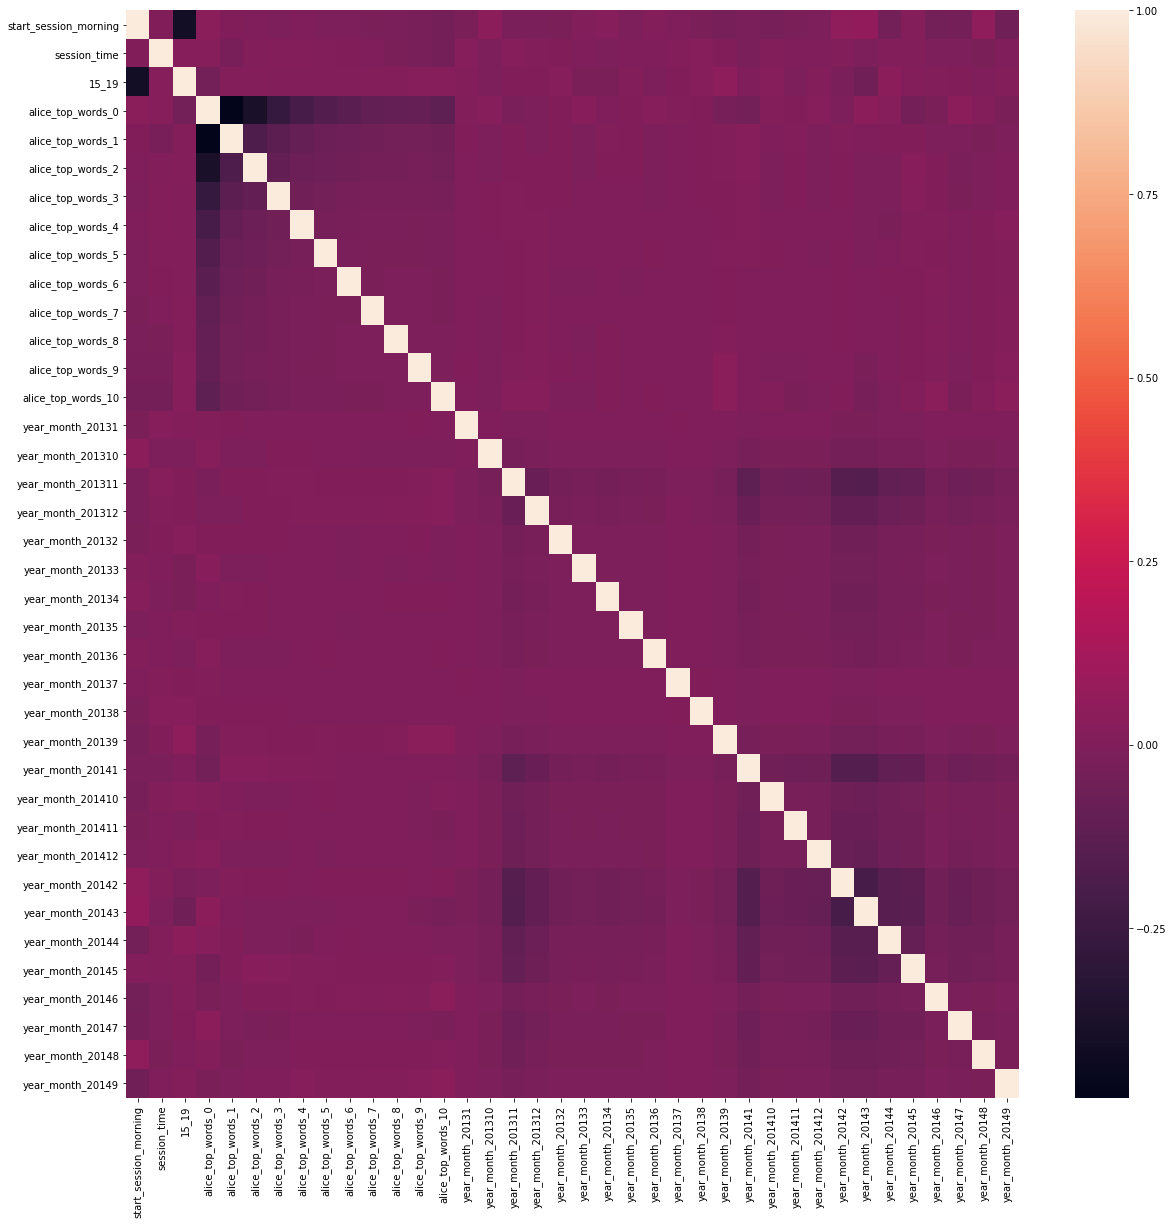

(336358, 38)
(336358, 150038)
CPU times: user 23.3 s, sys: 1.3 s, total: 24.6 s
Wall time: 23.3 s


In [12]:
%%time
full_df = pd.concat([train_df.drop('target', axis=1), test_df])


idx_split = train_df.shape[0]
#X_train1 = full_df[:idx_split, :]


X_full = build_features(full_df)
X_train = X_full[:idx_split, :]

In [ ]:
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.8):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [211]:
%%time
print(get_auc_lr_valid(X_train, y_train))


searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=skf
        ,random_state=17
        )
searchCV.fit(X_train, y_train)
print ('Max auc_roc:', searchCV.scores_[1].max())

# scaler = StandardScaler(with_mean=False)
# logit = LogisticRegression(random_state=17, class_weight='balanced')

# logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
# logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}
# print(logit_pipe_params)
# gcv7 = GridSearchCV( logit_pipe, param_grid = logit_pipe_params, scoring='roc_auc', cv=5)
# gcv7.fit(X_train, y_train)
# gcv7.best_score_

0.9552043120692071
Max auc_roc: 0.9260853775547901
CPU times: user 2min 50s, sys: 1min, total: 3min 50s
Wall time: 2min 35s


In [212]:
#list(np.power(10.0, np.arange(-10, 10)))



In [213]:
# Cs = list(np.power(10.0, np.arange(-10, 10)))
# print(len(Cs))
# print(searchCV.scores_[1].argmax())
# c = Cs[searchCV.scores_[1].argmax()]

In [214]:



#c = searchCV.coef_[0][searchCV.scores_[1].argmax()]
#print(get_auc_lr_valid(X_train, y_train, C =c))


In [215]:
#X_test_df = build_features(test_df)

In [216]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [217]:
# Make a prediction for test data set

X_test = X_full[idx_split:,:]


#X_test = X_test_df
y_test = searchCV.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_15.csv')

In [ ]:
searchCV.

In [ ]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]


print(X_train.shape)


# Calculate metric on the validation set
#print(get_auc_lr_valid(X_train, y_train))

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [ ]:
#train_df[train_df['start_session_morning'] == 1].head()

In [ ]:
from collections import Counter
alis_most_freq_sites = Counter(flatten)#.most_common(100)

#print(alis_most_freq_sites.most_common(10))
alis_top_sites  = sorted(alis_most_freq_sites, key=alis_most_freq_sites.get, reverse=True)[:100]

#print(alis_top_sites)
train_df['alis_top'] = (train_df[sites].astype(str).isin(alis_top_sites)==True).sum(axis=1)



Add features based on the session start time: hour, whether it's morning, day or night and so on.

# You code here
-кол-во сайтов в сессии из ТОП-10 принадлежащих Элис
-месяц начала сессии
-год начала сессии
-час н.с.
-день недели н.с.
-длительность сессии
-средняя длительность сессии

- час
- месяц
- день недели

- утро (0/1)
- ночь (0/1)
- ГГГГММ


сайт == слово 
row - предложение типо

т.е индексы сайтов нужно склеить через пробел в одну строку для каждой сессии, и к этому уже tfidf применять?


Я попробовал обратно замапить id-шники сайтов в URL, потом разбить на компоненты и сделать TF-IDF от получившихся слов. Но что-то это не помогло, хотя считало долго 

In [ ]:
train_data = pd.get_dummies(train_df[new_features], columns=['start_session_hour', 
                                        'start_session_day_of_the_week'])

train_data.head()

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [ ]:
# You code here
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data, y)
train_full = hstack((csr_matrix(train_data), X), format='csr')

#train_full[:100].todense().sum(axis=1)

Perform cross-validation with logistic regression.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=17
        ,max_iter=10000
        ,fit_intercept=True
        ,tol=10
    )
searchCV.fit(train_full, y)
print ('Max auc_roc:', searchCV.scores_)


Make prediction for the test set and form a submission file.

In [ ]:
test_pred = # You code here

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [ ]:
write_to_submission_file(test_pred, "assignment6_alice_submission.csv")